Importing Necessary libraries.

In [1]:
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

Loading datasets.

In [2]:
train_dataset = h5py.File('datasets/train_signs.h5', "r")
test_dataset = h5py.File('datasets/test_signs.h5', "r")

In [3]:
x_train = tf.data.Dataset.from_tensor_slices(train_dataset['train_set_x'])
y_train = tf.data.Dataset.from_tensor_slices(train_dataset['train_set_y'])

x_test = tf.data.Dataset.from_tensor_slices(test_dataset['test_set_x'])
y_test = tf.data.Dataset.from_tensor_slices(test_dataset['test_set_y'])

Showing the shape of the `x_train`, `y_train`, `x_test`, and `y_test` data sets.

In [4]:
print('x_train shape is :%i * %s' %(x_train.cardinality().numpy(),x_train.element_spec.shape))
print('x_test shape is :%i * %s' %(x_test.cardinality().numpy(),x_test.element_spec.shape))
print('y_train shape is :%i * 1' %(y_train.cardinality().numpy()))
print('y_test shape is :%i * 1' %(y_test.cardinality().numpy()))

x_train shape is :1080 * (64, 64, 3)
x_test shape is :120 * (64, 64, 3)
y_train shape is :1080 * 1
y_test shape is :120 * 1


The dataset that I'm  using is a subset of the sign language digits. It contains six different classes representing the digits from 0 to 5.

In [5]:
unique_labels = set()
for element in y_train:
    unique_labels.add(element.numpy())
print(unique_labels)

{0, 1, 2, 3, 4, 5}


Small sample of dataset shown as images.

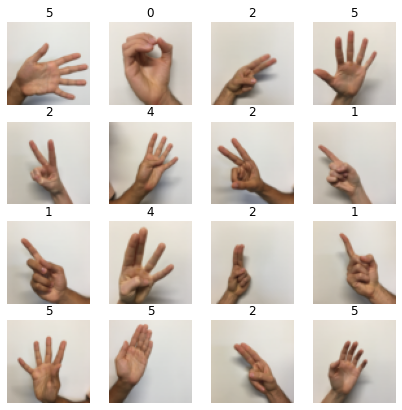

In [6]:
images_iter = iter(x_train)
labels_iter = iter(y_train)
plt.figure(figsize=(7,7))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(next(images_iter).numpy())
    plt.title(next(labels_iter).numpy())
    plt.axis("off")

Normalizing data and reshaping it.

In [7]:
def normalize(image):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [-1,])
    return image
new_test = x_test.map(normalize)
new_train = x_train.map(normalize)

print('new_train shape is :%i * %s' %(new_train.cardinality().numpy(),new_train.element_spec.shape))
print('new_test shape is :%i * %s' %(new_test.cardinality().numpy(),new_test.element_spec.shape))

new_train shape is :1080 * (12288,)
new_test shape is :120 * (12288,)


Computing the one hot encoding for single labels (0 to 5).

In [8]:
def one_hot_matrix(label, depth=6):
    one_hot = tf.reshape(tf.one_hot(label, depth, axis=0),(depth,))
    return one_hot

new_y_test = y_test.map(one_hot_matrix)
new_y_train = y_train.map(one_hot_matrix)

print('new_y_test shape is :%i * %s' %(new_y_test.cardinality().numpy(),new_y_test.element_spec.shape))
print('new_y_train shape is :%i * %s' %(new_y_train.cardinality().numpy(),new_y_train.element_spec.shape))

new_y_test shape is :120 * (6,)
new_y_train shape is :1080 * (6,)


Initializing the Parameters with Glorot initializer.


In [9]:
def initialize_parameters():                         
    initializer = tf.keras.initializers.GlorotNormal(seed=1)   
    W1 = tf.Variable(initializer(shape=(25,12288)))
    b1 = tf.Variable(initializer(shape=(25,1)))
    W2 = tf.Variable(initializer(shape=(12,25)))
    b2 = tf.Variable(initializer(shape=(12,1)))
    W3 = tf.Variable(initializer(shape=(6,12)))
    b3 = tf.Variable(initializer(shape=(6,1)))
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

parameters = initialize_parameters()

Implementing Forward Propagation.

In [11]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']

    Z1 = tf.add(tf.matmul(W1, X), b1)
    A1 = tf.keras.activations.relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)
    A2 = tf.keras.activations.relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)    
    
    return Z3

Computing the Cost.

In [12]:
def compute_cost(logits, labels):
    cost = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_true = tf.transpose(labels),y_pred = tf.transpose(logits),from_logits = True))
    return cost

Training the model:

In [13]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    costs = list()
    train_acc = list()
    test_acc = list()

    # Initializing parameters
    parameters = initialize_parameters()
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']   
    
    #using Adam optimizer and keras.metrics.CategoricalAccuracy() to calculate the accuracy of multi-class problem  
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    test_accuracy = tf.keras.metrics.CategoricalAccuracy()
    train_accuracy = tf.keras.metrics.CategoricalAccuracy()
    
    # Zipping X and Y sets into one dataset:
    dataset = tf.data.Dataset.zip((X_train, Y_train))
    test_dataset = tf.data.Dataset.zip((X_test, Y_test))
    m = dataset.cardinality().numpy() #getting the number of examples

    #Using prefetch to prevent memory jam:
    minibatches = dataset.batch(minibatch_size).prefetch(8)
    test_minibatches = test_dataset.batch(minibatch_size).prefetch(8)

    #Training loop
    for epoch in range(num_epochs):
        epoch_cost = 0
        train_accuracy.reset_states()
        for (minibatch_X, minibatch_Y) in minibatches:
            with tf.GradientTape() as tape:
                Z3 = forward_propagation(tf.transpose(minibatch_X),parameters)
                minibatch_cost = compute_cost(Z3,tf.transpose(minibatch_Y))
            train_accuracy.update_state(minibatch_Y, tf.transpose(Z3)) #Accumulating the accuracy of all the batches
            trainable_variables = [W1, b1, W2, b2, W3, b3]
            grads = tape.gradient(minibatch_cost, trainable_variables)
            optimizer.apply_gradients(zip(grads, trainable_variables)) #applying updates for each of the parameters
            epoch_cost += minibatch_cost
            epoch_cost /= m

            #Printing the cost every ten epochs:
        if print_cost == True and epoch % 10 == 0:
            print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            print("Train accuracy:", train_accuracy.result())

            for (minibatch_X, minibatch_Y) in test_minibatches:
                Z3 = forward_propagation(tf.transpose(minibatch_X), parameters)
                test_accuracy.update_state(minibatch_Y, tf.transpose(Z3))
            print("Test_accuracy:", test_accuracy.result())    

            costs.append(epoch_cost)
            train_acc.append(train_accuracy.result())
            test_acc.append(test_accuracy.result())
            test_accuracy.reset_states()    
    return parameters, costs, train_acc, test_acc

In [14]:
parameters, costs, train_acc, test_acc = model(new_train, new_y_train, new_test, new_y_test, num_epochs=100)

Cost after epoch 0: 0.001679
Train accuracy: tf.Tensor(0.19629629, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.16666667, shape=(), dtype=float32)
Cost after epoch 10: 0.001576
Train accuracy: tf.Tensor(0.32962963, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.35, shape=(), dtype=float32)
Cost after epoch 20: 0.001468
Train accuracy: tf.Tensor(0.47037038, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.45, shape=(), dtype=float32)
Cost after epoch 30: 0.001348
Train accuracy: tf.Tensor(0.52962965, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.525, shape=(), dtype=float32)
Cost after epoch 40: 0.001242
Train accuracy: tf.Tensor(0.58148146, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.55, shape=(), dtype=float32)
Cost after epoch 50: 0.001152
Train accuracy: tf.Tensor(0.6212963, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.55833334, shape=(), dtype=float32)
Cost after epoch 60: 0.001076
Train accuracy: tf.Tensor(0.6435185, shape=(), dtype=float32)
Tes

Ploting the Cost and the train/test accuracy.

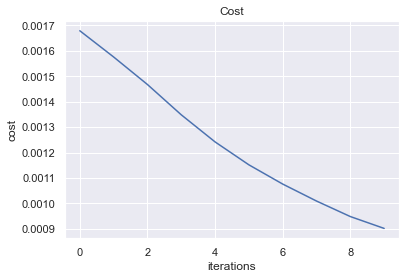

In [15]:
sns.set_theme()
plt.title("Cost" )
plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations')
plt.show()


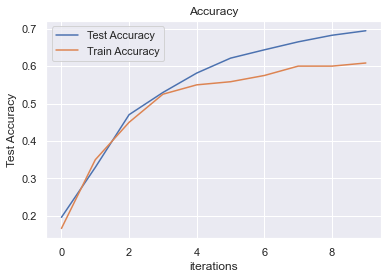

In [16]:
plt.plot(np.squeeze(train_acc))
plt.ylabel('Train Accuracy')
plt.xlabel('iterations')
plt.title("Accuracy" )

plt.plot(np.squeeze(test_acc))
plt.ylabel('Test Accuracy')
plt.xlabel('iterations')
plt.legend(labels=["Test Accuracy","Train Accuracy"])
plt.show()